# Predict the Twitter Accounts to be bots or not bots 
# Team Members: 
Ashish Bansal
John Martinez
Zhongheng Li


# Import modules

In [14]:
import numpy as np
import pandas as pd

from scipy.stats import entropy
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

/Users/Heng2j/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Preparion and Data Clearning: 

Import the file and create the dataframe and additional useful features

In [5]:
names=['id','id_str','screen_name','location','description','url','followers_count','friends_count','listedcount','created_at','favourites_count','verified','statuses_count','lang','status','default_profile','default_profile_image','has_extended_profile','name','bot']

In [6]:
df = pd.read_csv('/Users/Heng2j/Documents/NYU Grad /Spring 2017/Machine Learning/project/merged.csv',encoding="ISO-8859-1",
                 header=None,delim_whitespace=False,names=names,na_values='?',)

In [7]:
# Creating more features from given dataframe
df["screen_name_len"] = [len(i) for i in df["screen_name"]]
df["bot_is_substr"] = [int('bot' in i.lower()) for i in df["screen_name"]]
df["bot_in_des"] = [int('bot' in str(i).lower()) for i in df['description']]

# Getting the ages in years from created_at
ages = []
for i in df["created_at"]:
    if len(i) > 20:
        i = i.split()
        year = int(i[5][:4]) % 2000 
    else:
        i = i.split('/')
        year = int(i[2].split()[0]) % 2000
    age = 17-year
    ages.append(age)
df["age"] = ages


# Prepare dataframe
Normally randomized the data and split the training dataframe and test dataframe

In [48]:
for a in range(1000):
    randomized_Data = df.reindex(np.random.permutation(df.index))

train_df = randomized_Data[:int((len(randomized_Data)+1)*.80)]
test_df = randomized_Data[int((len(randomized_Data)+1)*.80):] 





In [56]:
#Create the Predicting Variables and Targeting Variables for Traning and Test sets
X_train = train_df.drop('bot', 1)
Y_train = train_df['bot']


X_test = test_df.drop('bot', 1)
Y_test = test_df['bot']

# Traning Models - Decision Tree


Traning Average accuracy: 0.864983576759
Traning Average Precision: 0.863809581514
Accuracy on test set:  0.883408071749


{'age': 0.41492965677067173,
 'bot_in_des': 0.021081717753239609,
 'bot_is_substr': 0.0067882688992727752,
 'favourites_count': 0.10788413418498848,
 'followers_count': 0.082505942249791672,
 'friends_count': 0.16744333519166496,
 'listedcount': 0.025622599485142093,
 'screen_name_len': 0.047866973396534632,
 'statuses_count': 0.093995972566376859,
 'verified': 0.031881399502317213}

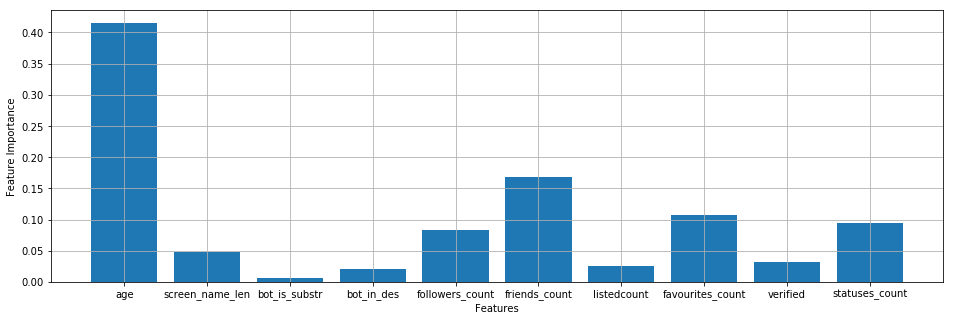

In [67]:
dt = DecisionTreeClassifier(criterion='entropy')

# treeNames are only the numerical and binary features with importance > 0 
treeNames=['age','screen_name_len', 'bot_is_substr','bot_in_des','followers_count','friends_count','listedcount', 'favourites_count','verified','statuses_count']

# Getting the training sets and fitting the tree
df_train = train_df[treeNames+['bot']]
x_train = train_df[treeNames]
y_train = train_df.bot.astype(bool)
dt.fit(x_train, y_train)

# Evaluating the tree with cross-val
accuracy = cross_val_score(dt, x_train, y_train, cv=5, scoring = "accuracy")
precision = cross_val_score(dt, x_train, y_train, cv=5, scoring = "precision")

# Graphing the feature importance 
import matplotlib.pyplot as plt
%matplotlib inline

feature_mi_dict = dict(zip(df_train.columns.values,dt.feature_importances_))
feature_mi_dict
feature_importance_X = feature_mi_dict.keys()
feature_importance_Y = feature_mi_dict.values()
plt.rcParams['figure.figsize'] = (16, 5)
plt.bar(range(len(feature_mi_dict)), feature_mi_dict.values(), align='center')
plt.xticks(range(len(feature_mi_dict)), feature_mi_dict.keys())
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.grid(True)

# Printing the evaluations 
print("Traning Average accuracy:",accuracy.mean())
print("Traning Average Precision:",precision.mean())


predicts = dt.predict(X_test[treeNames])

Test_accuracy = metrics.accuracy_score(test_df['bot'], predicts)

print('Accuracy on test set: ',Test_accuracy )





feature_mi = dt.feature_importances_

feature_mi

feature_mi_dict = dict(zip(x_train.columns.values,feature_mi))

feature_mi_dict

In [87]:
def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
   
    fpr, tpr, thresholds = roc_curve(truth,preds, pos_label=1)
    roc_auc = auc(fpr,tpr)

    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds,pos_label=1 )
        roc_auc = auc(fpr, tpr)

    c = (np.random.rand(), np.random.rand(), np.random.rand())

    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

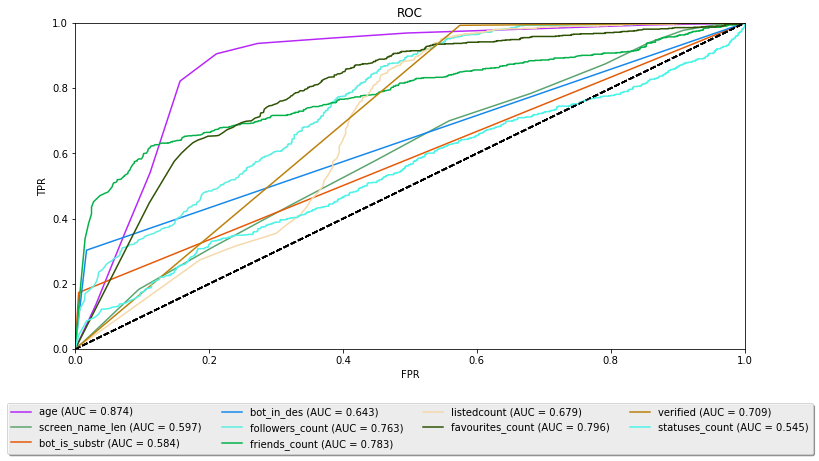

In [88]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

train_df_modf = train_df[treeNames]


feature_auc_dict = {}
for col in train_df_modf.columns:
    feature_auc_dict[col] = plotUnivariateROC(train_df_modf[col], Y_train, col)


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [64]:



# Splitting the set 80-20 with train_test_split from sklearn metrics
#bot = df['bot']
#X_train, X_test, Y_train, Y_test = train_test_split(df[treeNames].ix[:,0:13], bot, test_size=0.2, random_state=42)


min_samples_split_values = list(range(20,70,5))
min_samples_leaf_values = list(range(20,30,1))

test_set_accuracy = []

for i in range(10):
    
    min_samples_split_value = min_samples_split_values[i]
    for j in range(10):
        min_samples_leaf_value = min_samples_leaf_values[j]    
        
        # Fitting and evaluating a tree
        splitDt = DecisionTreeClassifier(criterion='entropy',max_depth = 5, min_samples_split = min_samples_split_value,  min_samples_leaf = min_samples_leaf_value)
        splitDt.fit(X_train[treeNames], Y_train)
        predict = splitDt.predict(X_test[treeNames])
        accuracy = metrics.accuracy_score(predict, Y_test)
    
        test_set_accuracy.append(accuracy)

        
        
print("Maximum Accuracy:", max(test_set_accuracy),"\nMinimum Accuracy:", min(test_set_accuracy))
print("Average Accuracy:",sum(test_set_accuracy)/len(test_set_accuracy))





Maximum Accuracy: 0.887892376682 
Minimum Accuracy: 0.881165919283
Average Accuracy: 0.884125560538
